## Import data and preprocessing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [4]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [6]:
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Hyperparameter tuning

In [7]:
import keras_tuner as kt

In [8]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [9]:
def build_model(hp):

    model = Sequential()

    ## variable number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=10)

    for i in range(num_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[8, 16, 32, 64, 128])
        activations = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid', 'linear'])

        if i == 0: # first hidden layer
            model.add(Dense(units=num_units, activation=activations, input_dim=8))

        else: # other hidden layer
            model.add(Dense(units=num_units, activation=activations))
        
    ## output layer
    model.add(Dense(units=1, activation='sigmoid'))

    ## Compile the model
    optimizers = hp.Choice('optimizer', values=['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop'])
    model.compile(loss='binary_crossentropy', optimizer=optimizers, metrics=['accuracy'])

    return model

In [10]:
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=10,
                        directory='tune_all_params')

Reloading Tuner from tune_all_params\untitled_project\tuner0.json


In [11]:
tuner.search(X, y, epochs=5, validation_data=(X_test, y_test))

In [12]:
best_params = tuner.get_best_hyperparameters()[0].values
best_params

{'num_layers': 9,
 'num_units_0': 128,
 'activation_0': 'tanh',
 'optimizer': 'nadam',
 'num_units_1': 128,
 'activation_1': 'tanh',
 'num_units_2': 16,
 'activation_2': 'linear',
 'num_units_3': 128,
 'activation_3': 'relu',
 'num_units_4': 32,
 'activation_4': 'tanh',
 'num_units_5': 128,
 'activation_5': 'sigmoid',
 'num_units_6': 32,
 'activation_6': 'sigmoid',
 'num_units_7': 32,
 'activation_7': 'relu',
 'num_units_8': 8,
 'activation_8': 'relu'}

## Train the best model

In [18]:
model = Sequential()

## Hidden layers
model.add(Dense(units=128, activation='tanh', input_dim=8))
model.add(Dense(units=128, activation='tanh'))
model.add(Dense(units=16, activation='linear'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='tanh'))
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=8, activation='relu'))

## Output layers
model.add(Dense(units=1, activation='sigmoid'))

## Compile model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.name = 'tuned_model'
model.summary()

c:\Users\7200\AppData\Local\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "tuned_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,713 (139.50 KB)

 Trainable params: 35,713 (139.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X, y, epochs=100, validation_data=(X_test, y_test))
history = history.history

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4415 - loss: 0.7147 - val_accuracy: 0.6039 - val_loss: 0.6457
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6527 - loss: 0.6034 - val_accuracy: 0.7338 - val_loss: 0.5817
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7806 - loss: 0.5312 - val_accuracy: 0.7468 - val_loss: 0.5492
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7806 - loss: 0.4900 - val_accuracy: 0.7273 - val_loss: 0.5491
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8040 - loss: 0.4641 - val_accuracy: 0.7403 - val_loss: 0.5339
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7674 - loss: 0.4866 - val_accuracy: 0.7468 - val_loss: 0.5314
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7876 - loss: 0.4556 - val_accuracy: 0.7403 - val_loss: 0.5250
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.4704 - val_accuracy: 0.7338 - 

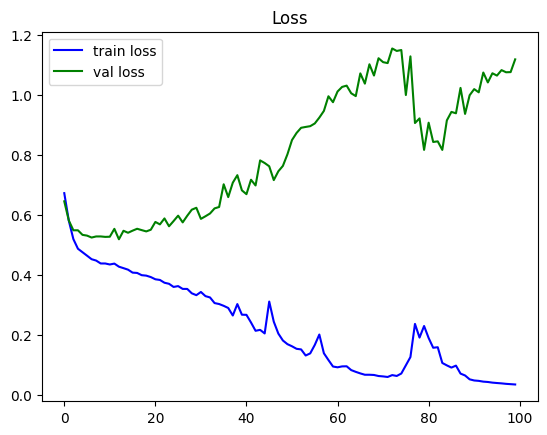

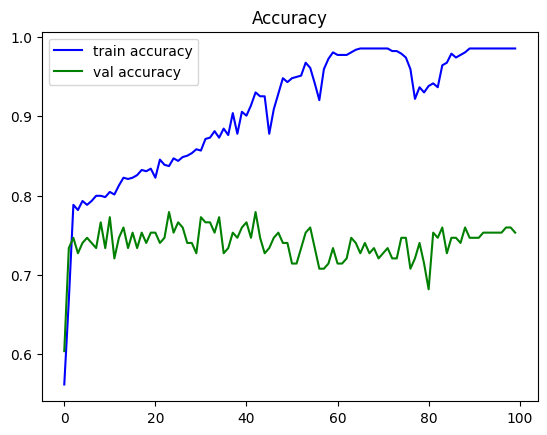

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(history['loss'], label='train loss', color='blue')
plt.plot(history['val_loss'], label='val loss', color='green')
plt.title('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

plt.plot(history['accuracy'], label='train accuracy', color='blue')
plt.plot(history['val_accuracy'], label='val accuracy', color='green')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('accuracy.png')

In [21]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7532467532467533